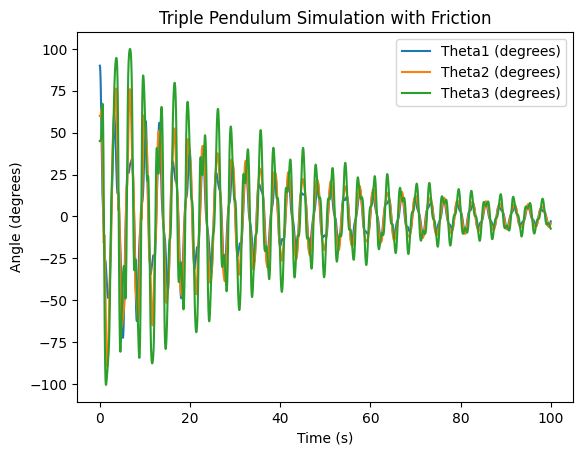

In [5]:
from __future__ import division, print_function
from math import sin, cos, pi, radians, degrees
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

# Physical constants
g = 9.81  # Acceleration due to gravity (m/s^2)
l1 = 1.0  # Length of the first pendulum (m)
l2 = 1.0  # Length of the second pendulum (m)
l3 = 1.0  # Length of the third pendulum (m)
m1 = 1.0  # Mass of the first pendulum (kg)
m2 = 1.0  # Mass of the second pendulum (kg)
m3 = 1.0  # Mass of the third pendulum (kg)

# Friction/damping coefficients
damping1 = 0.05  # Damping for the first pendulum
damping2 = 0.05  # Damping for the second pendulum
damping3 = 0.05  # Damping for the third pendulum

def f(q, t):
    '''Triple Pendulum equation of motion with friction'''
    theta1, omega1, theta2, omega2, theta3, omega3 = q

    # Useful constants
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012 / 4

    # Useful sines and cosines
    sin0 = sin(theta1)
    sin1 = sin(theta2)
    sin2 = sin(theta3)
    cos01 = cos(theta1 - theta2)
    cos02 = cos(theta1 - theta3)
    cos12 = cos(theta2 - theta3)
    sin01 = sin(theta1 - theta2)
    sin02 = sin(theta1 - theta3)
    sin12 = sin(theta2 - theta3)

    # Recurrent patterns
    r1 = m12 * cos01 * cos02 - m012 * cos12
    r2 = m012 - m12 * cos01**2
    r3 = -m012 + m3 * cos02**2

    # Parts of the first equation
    od1_1 = 4 * m3 * m12
    od1_2 = r1 * cos01 + r2 * cos02
    od1_3 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od1_4 = (-g * (m2 + m3) * sin1
             + l1 * (m2 + m3) * sin01 * omega1**2
             - l3 * m3 * sin12 * omega3**2)
    od1_5 = -m3 * m12 * (cos02 - cos(theta1 - 2 * theta2 + theta3))**2 * m012
    od1_6 = (g * m012 * sin0
             + l2 * m12 * sin01 * omega2**2
             + l3 * m3 * sin02 * omega3**2)
    od1_7 = m3 * r1**2 + m12 * r3 * r2

    # Parts of the second equation
    od2_1 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od2_2 = g * m012 * sin0 + l2 * m12 * sin01 * omega2**2 + l3 * m3 * sin02 * omega3**2
    od2_3 = -g * (m2 + m3) * sin1 + l1 * (m2 + m3) * sin01 * omega1**2 - l3 * m3 * sin12 * omega3**2

    # Parts of the third equation
    od3_1 = g * m012 * sin0 + l2 * m12 * sin01 * omega2**2 + l3 * m3 * sin02 * omega3**2
    od3_2 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od3_3 = g * (m2 + m3) * sin1 - l1 * (m2 + m3) * sin01 * omega1**2 + l3 * m3 * sin12 * omega3**2

    # ThetaDot equations
    td1 = omega1
    td2 = omega2
    td3 = omega3

    # OmegaDot equations
    od1 = (mf * (od1_1 * od1_2 * od1_3 * r2
           - 4 * (-m3 * od1_2 * r1
                  + (m3 * r1**2 + m12 * r3 * r2) * cos01) * od1_4
           - (od1_5 + 4 * m3 * r1**2 + 4 * m12 * r3 * r2) * od1_6)
           / (l1 * od1_7 * m012 * r2)) - damping1 * omega1

    od2 = ((-m3 * r1 * m012 * od2_1 * r2
           - (m3 * (r1 * cos01 + r2 * cos02) * r1
              - (m3 * r1**2 + m12 * r3 * r2) * cos01) * od2_2
           + m012 * r3 * r2 * od2_3)
           / (l2 * od1_7 * r2)) - damping2 * omega2

    od3 = (-(m12 * od1_2 * od3_1
           + m12 * m012 * od3_2 * r2
           - r1 * m012 * od3_3)
           / (l3 * (m3 * r1**2 + m12 * r3 * r2))) - damping3 * omega3

    return array([td1, od1, td2, od2, td3, od3], float)

# Simulation parameters
a = 0.0  # Start time
b = 100.0  # End time
N = 10000  # Number of time steps
h = (b - a) / N  # Time step size

# Time points
tpoints = arange(a, b, h)

# Pre-allocate arrays for theta1, theta2, theta3
theta1_points = zeros_like(tpoints)
theta2_points = zeros_like(tpoints)
theta3_points = zeros_like(tpoints)

# Initial conditions in radians
initial_conditions = [pi / 2, 0, pi / 3, 0, pi / 4, 0]

# Convert initial conditions to radians
q = array(initial_conditions, float)

# Runge-Kutta 4th order method loop
for i, t in enumerate(tpoints):
    theta1_points[i] = degrees(q[0])  # Convert radians to degrees for plotting
    theta2_points[i] = degrees(q[2])  # Convert radians to degrees for plotting
    theta3_points[i] = degrees(q[4])  # Convert radians to degrees for plotting

    # RK4 coefficients
    k1 = h * f(q, t)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(q + k3, t + h)

    # Update the state vector
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Plotting
plt.plot(tpoints, theta1_points, label='Theta1 (degrees)')
plt.plot(tpoints, theta2_points, label='Theta2 (degrees)')
plt.plot(tpoints, theta3_points, label='Theta3 (degrees)')
plt.title("Triple Pendulum Simulation with Friction")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.show()